## Analysis with ML

## 6. Cluster Analysis with Agglomerative Clustering (Doesnt work well)

We'll group instruments based on their statistical properties (e.g., correlation clusters) to identify similar trading behaviors using the Agglomerative Clustering algorithm, which might handle the data distribution better than K-means (tested and didn't work well..).


## 7. Cluster Analysis with Gaussian Mixture Model (GMM) (Doesn't work well)

We'll group instruments based on their statistical properties (e.g., correlation clusters) to identify similar trading behaviors using the Gaussian Mixture Model (GMM) algorithm, which might handle the data distribution better than K-means or Agglomerative Clustering.


## Issues with K-Means analysis
- Assumes clusters are spherical and evenly sized.
- Requires pre-specifying the number of clusters.
- Sensitive to initial centroid placement and can converge to local minima.
- Not effective for clusters of varying sizes and densities.

In [2]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Incorporating Multiple Features for Clustering

We'll calculate technical indicators such as RSI, volatility, and MACD, combine these features with correlation data, and then perform hierarchical clustering on the enhanced feature set with 10 clusters.


In [3]:
from sklearn.preprocessing import StandardScaler

# Load the price data
prices = np.loadtxt('prices.txt')

# Convert to DataFrame for easier analysis
df = pd.DataFrame(prices, columns=[f'Instrument_{i}' for i in range(prices.shape[1])])

# Calculate daily returns
returns = df.pct_change().dropna()

# Calculate RSI
def calculate_rsi(prices, window=14):
    deltas = np.diff(prices)
    seed = deltas[:window+1]
    up = seed[seed >= 0].sum() / window
    down = -seed[seed < 0].sum() / window
    rs = up / down
    rsi = np.zeros_like(prices)
    rsi[:window] = 100. - 100. / (1. + rs)
    
    for i in range(window, len(prices)):
        delta = deltas[i - 1]

        if delta > 0:
            up_val = delta
            down_val = 0.
        else:
            up_val = 0.
            down_val = -delta

        up = (up * (window - 1) + up_val) / window
        down = (down * (window - 1) + down_val) / window

        rs = up / down
        rsi[i] = 100. - 100. / (1. + rs)

    return rsi

# Calculate RSI for each instrument
rsi_features = np.array([calculate_rsi(df[f'Instrument_{i}']) for i in range(df.shape[1])]).T

# Calculate MACD
def calculate_macd(prices, slow=26, fast=12, signal=9):
    exp1 = prices.ewm(span=fast, adjust=False).mean()
    exp2 = prices.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

# Calculate MACD for each instrument
macd_features = []
signal_features = []
for i in range(df.shape[1]):
    macd, signal = calculate_macd(df[f'Instrument_{i}'])
    macd_features.append(macd)
    signal_features.append(signal)

macd_features = np.array(macd_features).T
signal_features = np.array(signal_features).T

# Determine the minimum number of rows across all feature arrays
min_length = min(returns.shape[0], rsi_features.shape[0], macd_features.shape[0], signal_features.shape[0])

# Truncate all arrays to this length
returns = returns.iloc[:min_length, :]
rsi_features = rsi_features[:min_length, :]
macd_features = macd_features[:min_length, :]
signal_features = signal_features[:min_length, :]

# Combine features for each instrument
combined_features = []
for i in range(df.shape[1]):
    instrument_features = np.hstack([
        returns.iloc[:, i].values.reshape(-1, 1),
        rsi_features[:, i].reshape(-1, 1),
        macd_features[:, i].reshape(-1, 1),
        signal_features[:, i].reshape(-1, 1)
    ])
    combined_features.append(instrument_features.flatten())

combined_features = np.array(combined_features)

# Standardize the features to have mean=0 and variance=1
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_features)
linked = linkage(scaled_features, method='ward')


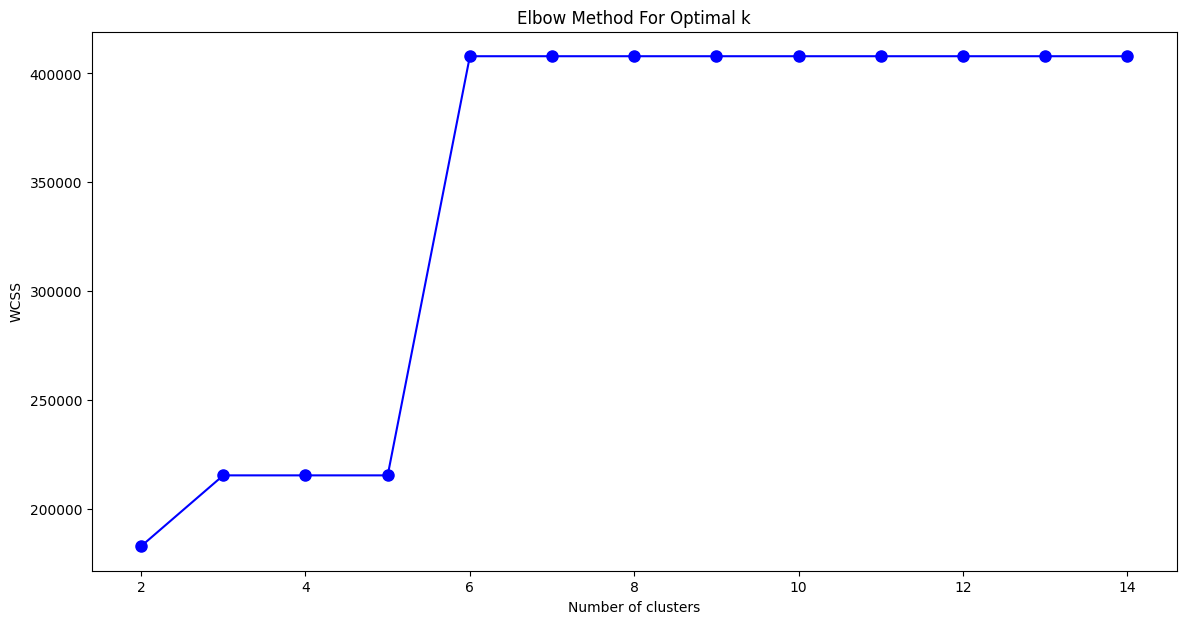

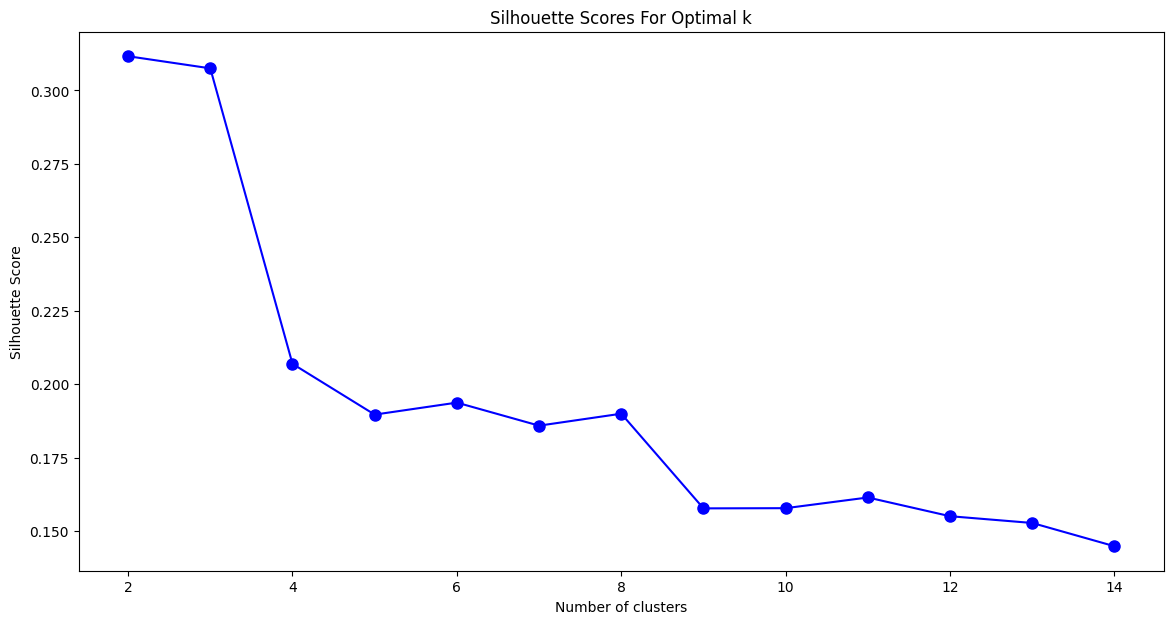

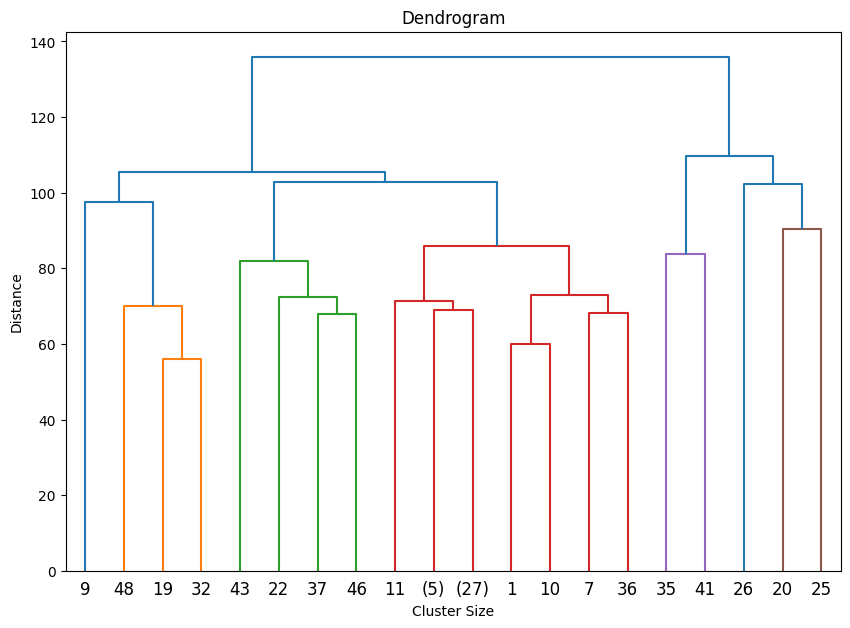

In [4]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram

# Function to plot the dendrogram
def plot_dendrogram(linked):
    plt.figure(figsize=(10, 7))
    dendrogram(linked, truncate_mode='level', p=5)
    plt.title("Dendrogram")
    plt.xlabel("Cluster Size")
    plt.ylabel("Distance")
    plt.show()

# Calculate WCSS for a range of cluster numbers
wcss = []
silhouette_scores = []
K = range(2, 15)

for k in K:
    clusters = fcluster(linked, k, criterion='maxclust')
    wcss.append(np.sum((scaled_features - np.mean(scaled_features[clusters == k], axis=0))**2))
    silhouette_scores.append(silhouette_score(scaled_features, clusters))

# Plotting the Elbow Method graph
plt.figure(figsize=(14, 7))
plt.plot(K, wcss, 'bo-', markersize=8)
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Plotting the Silhouette Score graph
plt.figure(figsize=(14, 7))
plt.plot(K, silhouette_scores, 'bo-', markersize=8)
plt.title('Silhouette Scores For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Plot the dendrogram
plot_dendrogram(linked)


In [5]:
n_clusters = 5 # Best cluster size from elbow method

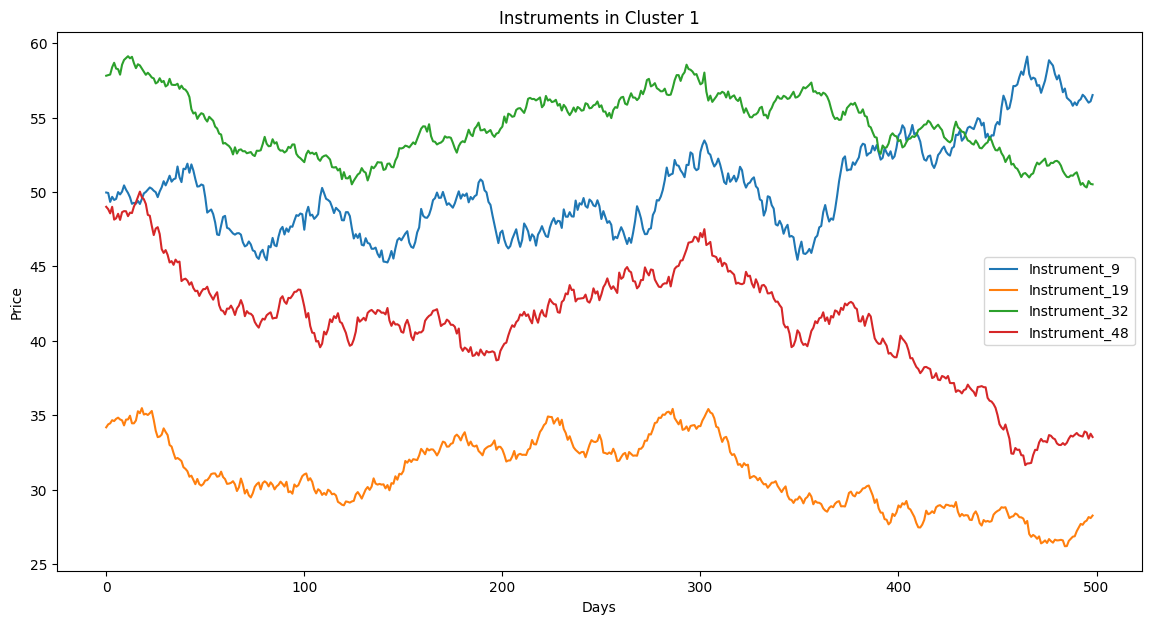

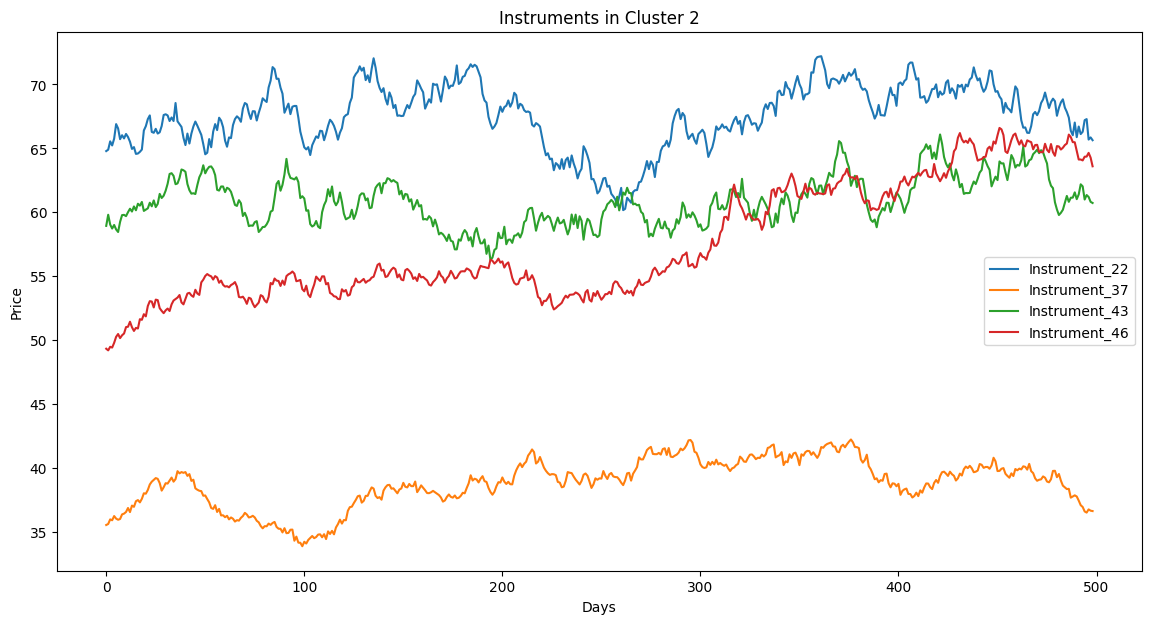

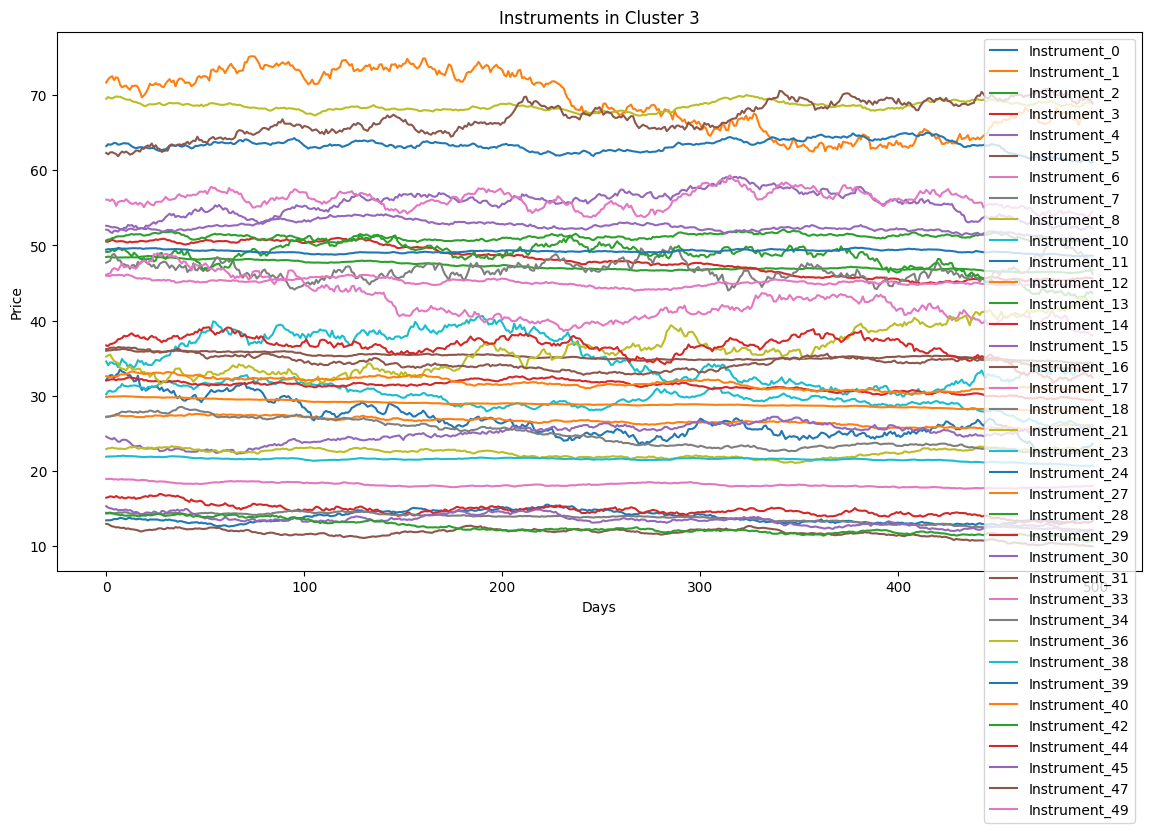

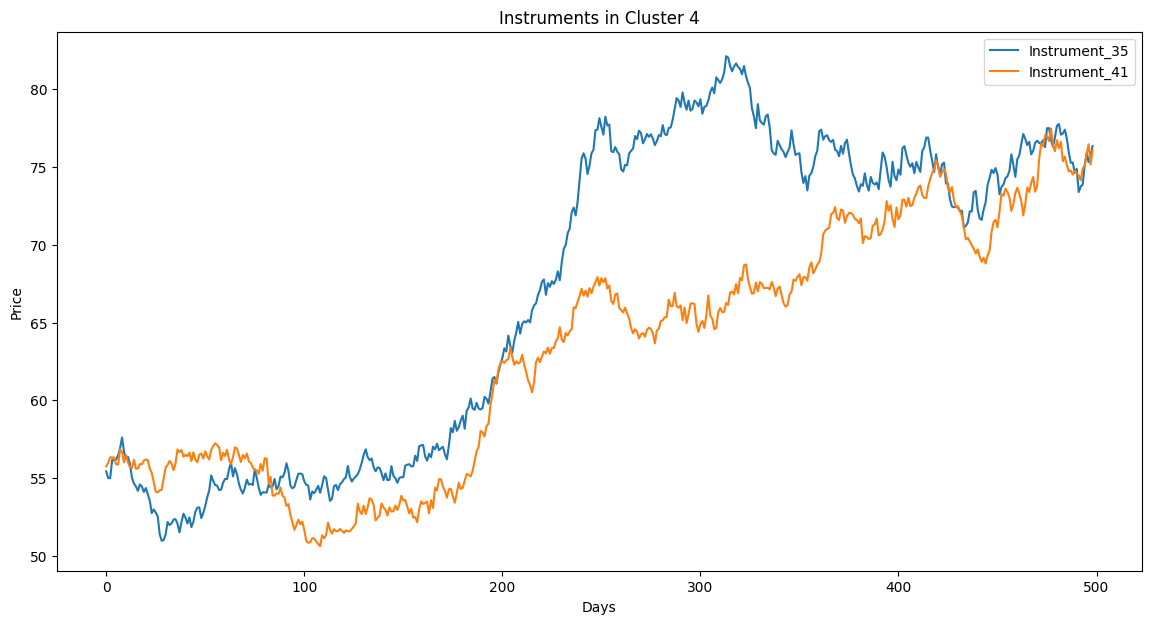

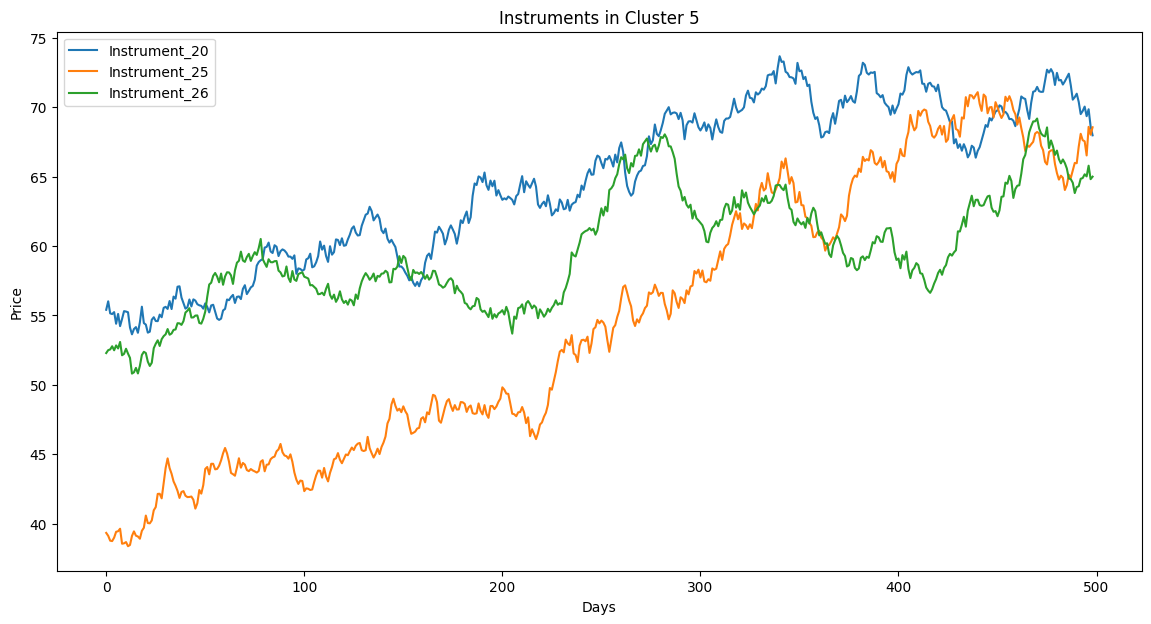

In [6]:

# Perform hierarchical clustering with 10 clusters
clusters = fcluster(linked, n_clusters, criterion='maxclust')

# Assign clusters to instruments
instrument_clusters = pd.DataFrame({'Instrument': df.columns, 'Cluster': clusters})

# Plot instruments by clusters
for cluster in np.unique(clusters):
    cluster_instruments = instrument_clusters[instrument_clusters['Cluster'] == cluster]['Instrument']
    plt.figure(figsize=(14, 7))
    for instrument in cluster_instruments:
        plt.plot(df.index[:min_length], df[instrument][:min_length], label=instrument)
    plt.title(f'Instruments in Cluster {cluster}')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


## Calculate and Plot Correlation Matrices for Each Cluster

We'll calculate and plot the correlation matrices for each of the 5 clusters, excluding cluster 3.


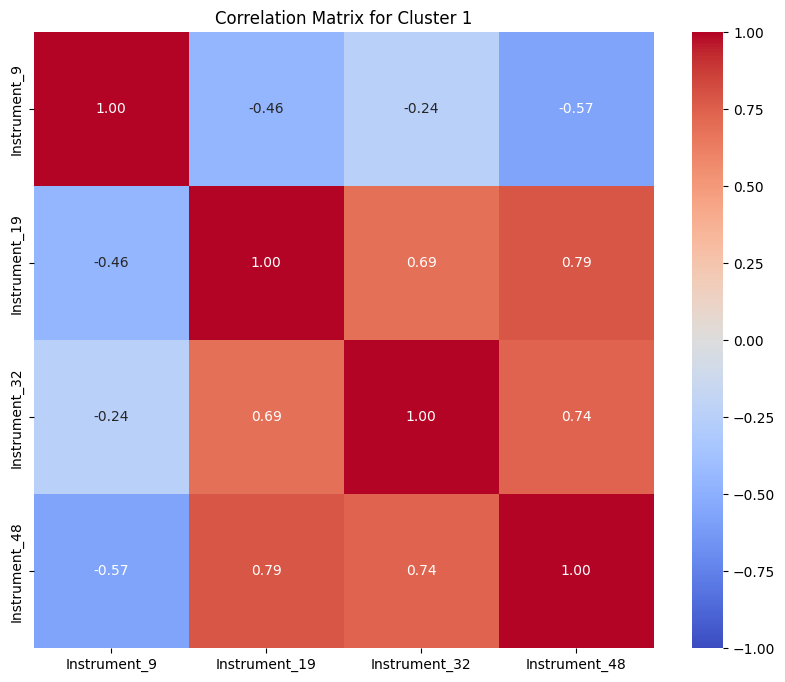

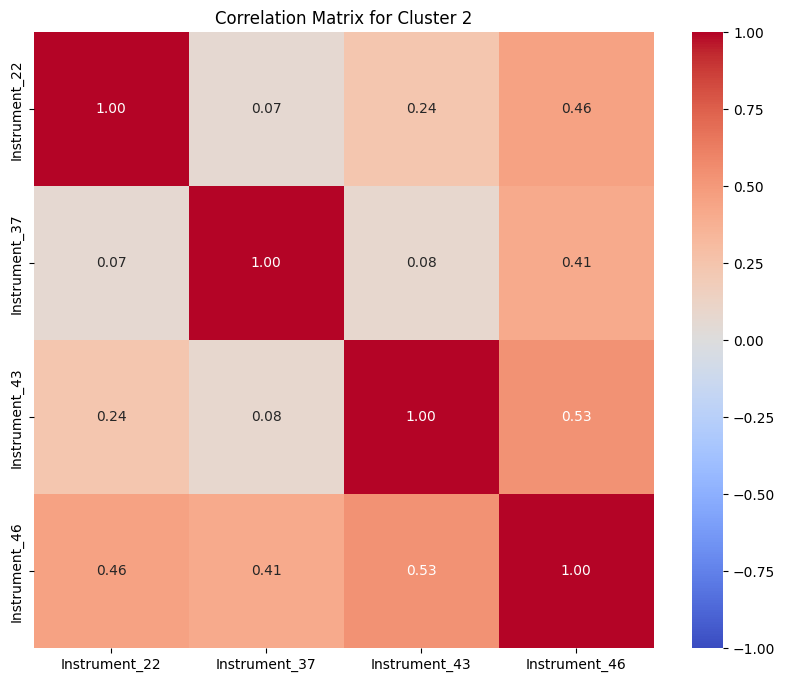

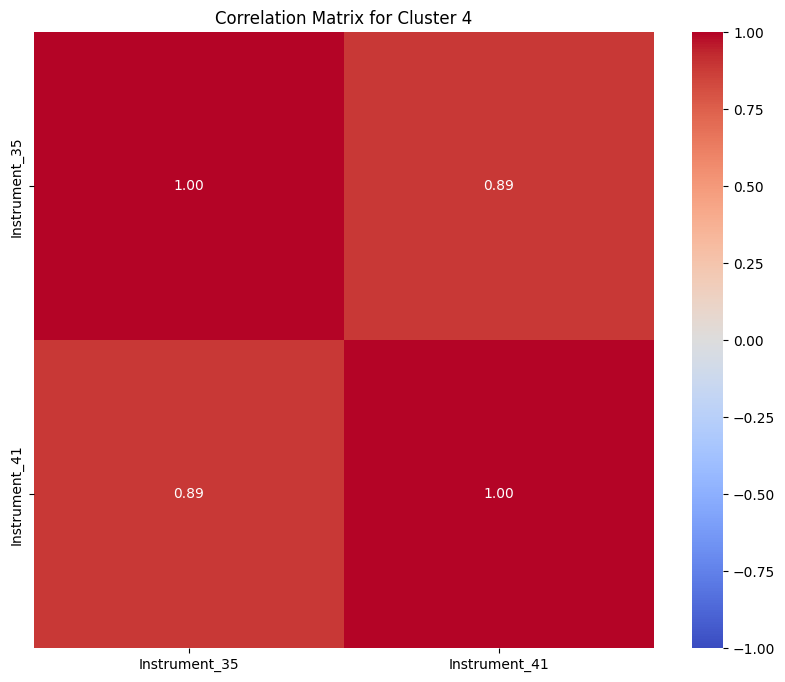

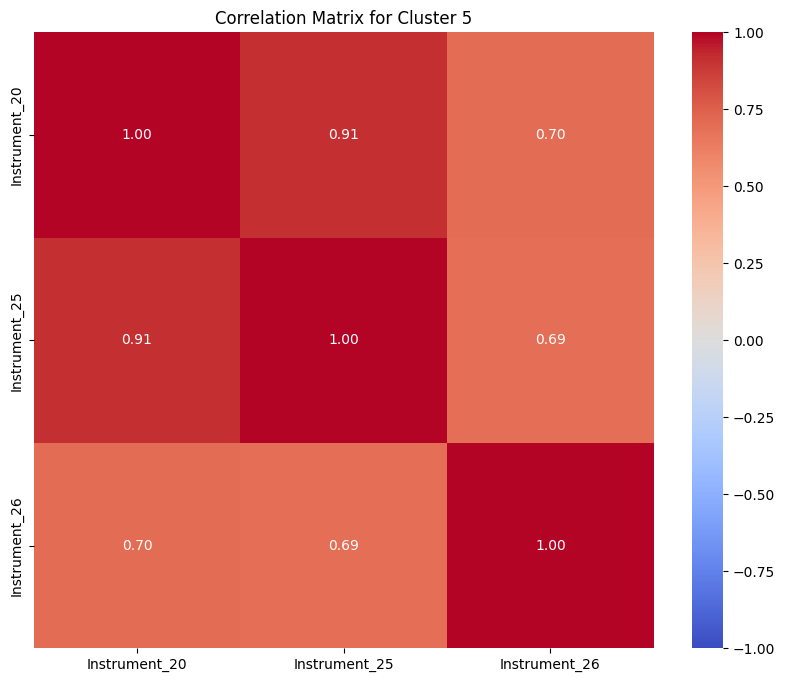

In [7]:
import seaborn as sns

# Calculate and plot correlation matrices for each cluster, excluding cluster 3
for cluster in np.unique(clusters):
    if cluster == 3:
        continue
    cluster_instruments = instrument_clusters[instrument_clusters['Cluster'] == cluster]['Instrument']
    cluster_data = df[cluster_instruments]
    corr_matrix = cluster_data.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix for Cluster {cluster}')
    plt.show()


## Calculate and Plot Correlation Matrices, RSI, MACD, and Volatility for Clusters 1, 2, 4, and 5

We'll calculate and plot the correlation matrices, RSI (with overbought and oversold lines), MACD (with histograms), and volatility for clusters 1, 2, 4, and 5, excluding cluster 3.


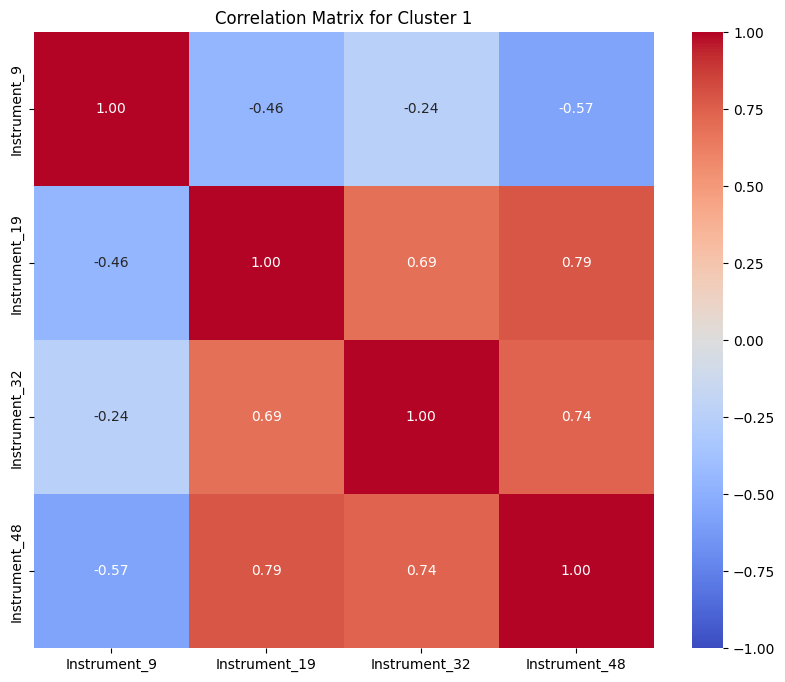

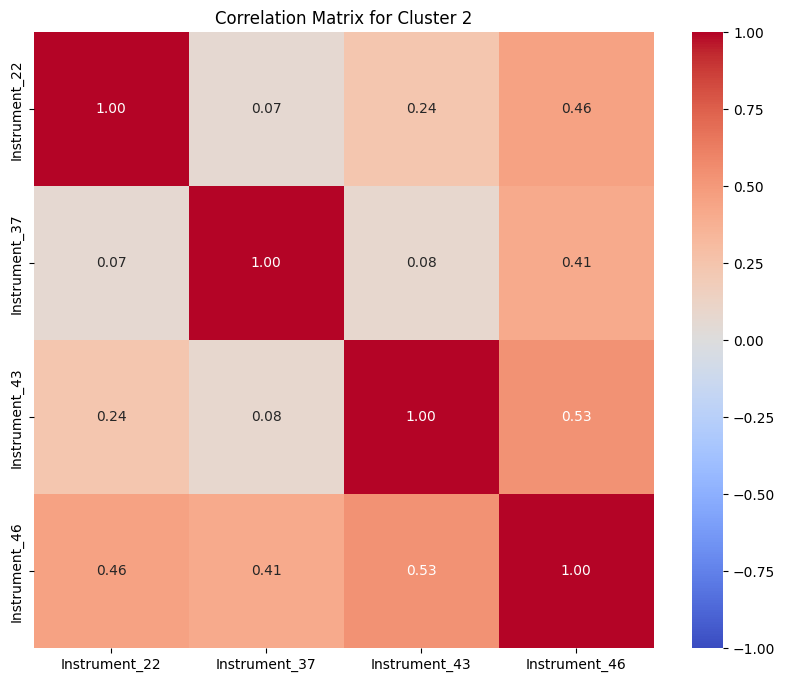

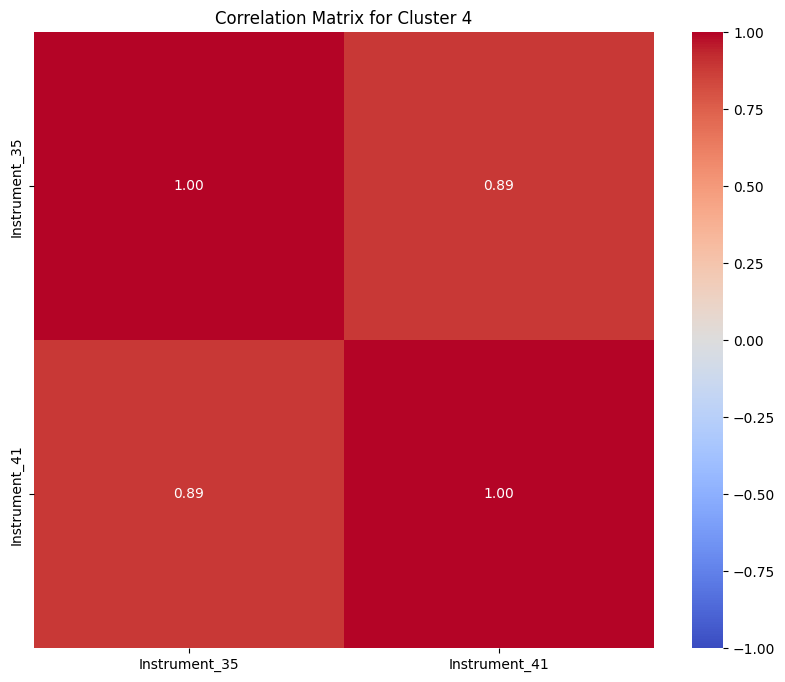

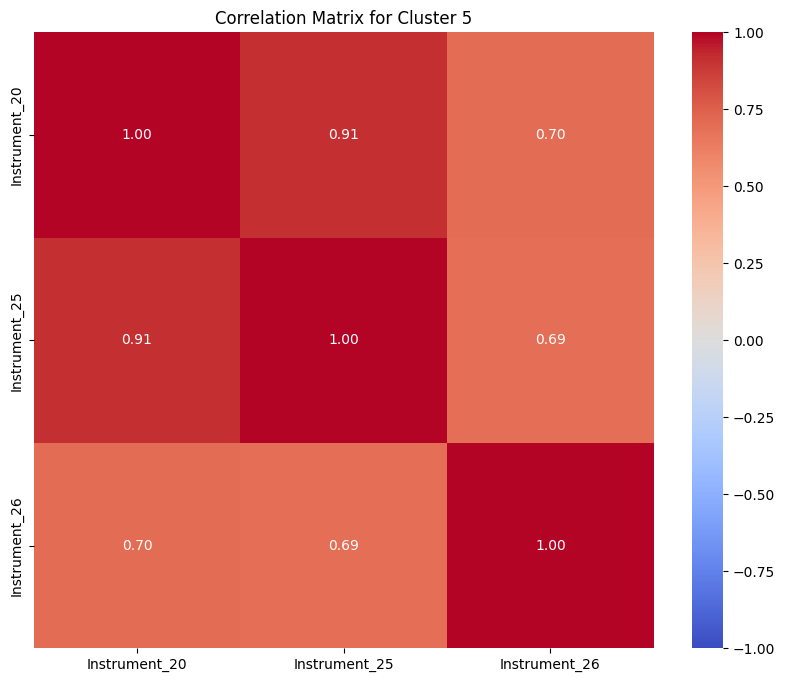

In [9]:
# Calculate and plot correlation matrices for each cluster, excluding cluster 3
for cluster in np.unique(clusters):
    if cluster == 3:
        continue
    cluster_instruments = instrument_clusters[instrument_clusters['Cluster'] == cluster]['Instrument']
    cluster_data = df[cluster_instruments]
    corr_matrix = cluster_data.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix for Cluster {cluster}')
    plt.show()

In [ ]:
# Calculate and plot RSI, MACD, and Volatility for clusters 1, 2, 4, and 5
selected_clusters = [1, 2, 4, 5]

for cluster in selected_clusters:
    cluster_instruments = instrument_clusters[instrument_clusters['Cluster'] == cluster]['Instrument']
    
    # Plot RSI
    plt.figure(figsize=(14, 7))
    for instrument in cluster_instruments:
        rsi = calculate_rsi(df[instrument])
        plt.plot(df.index[-len(rsi):], rsi, label=instrument)
    plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
    plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
    plt.title(f'RSI for Cluster {cluster}')
    plt.xlabel('Days')
    plt.ylabel('RSI')
    plt.legend()
    plt.show()
    
    # Plot MACD
    plt.figure(figsize=(14, 10))
    for instrument in cluster_instruments:
        macd, signal = calculate_macd(df[instrument])
        plt.subplot(311)
        plt.plot(df.index[-len(macd):], macd, label=f'MACD {instrument}')
        plt.plot(df.index[-len(signal):], signal, linestyle='--', label=f'Signal {instrument}')
        plt.title(f'MACD for Cluster {cluster}')
        plt.xlabel('Days')
        plt.ylabel('MACD')
        plt.legend()
        
        plt.subplot(312)
        macd_histogram = macd - signal
        plt.bar(df.index[-len(macd_histogram):], macd_histogram, label=f'Histogram {instrument}')
        plt.title(f'MACD Histogram for Cluster {cluster}')
        plt.xlabel('Days')
        plt.ylabel('MACD Histogram')
        plt.legend()
        
    plt.tight_layout()
    plt.show()
    
    # Plot Volatility
    plt.figure(figsize=(14, 7))
    for instrument in cluster_instruments:
        volatility = returns[instrument].rolling(window=14).std()
        plt.plot(df.index[-len(volatility):], volatility, label=instrument)
    plt.title(f'Volatility for Cluster {cluster}')
    plt.xlabel('Days')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()